# Tabular Data Regression Example

In this example, we demonstrate how to use dlpy to build a simple neural network for tabular data regression problems. 

The california housing dataset we used here is contained in the sklearn package. More details about the data can be found here:https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset

Key steps involved:
1. Upload data to the server
2. Build and train a fully connected feedforward neural network model with dlpy.
3. Predict on the testing dataset.
4. Evaluate the training and testing loss

### 1. Import python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import fetch_california_housing #The dataset is from sklearn package, with version >= 0.20.1
from swat.cas import datamsghandlers
from swat import CAS, CASTable
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import explained_variance_score, mean_squared_error, mean_absolute_error
%matplotlib inline

### 2. Connect to CAS server

In [2]:
conn = CAS('host_name', port_number)

### 3. Load examples dataset from scikit-learn

In [3]:
# load the california housing data
california_housing = fetch_california_housing()

# Get data into two pandas dataframes for the predictors(ch_x_df) and target(ch_y_df). 
ch_x_df = pd.DataFrame(california_housing['data'], columns=california_housing['feature_names'])
ch_y_df = pd.DataFrame(california_housing['target'], columns=['house_value'])

# Concatenate the data into one dataframe
ch_df = pd.concat([ch_x_df, ch_y_df], axis=1)

In [4]:
ch_df.loc[:10]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


### 4. Upload the pandas dataframe to server

In [5]:
tbl = conn.upload_frame(ch_df, casout=dict(name='ch_df', replace=True));

NOTE: Cloud Analytic Services made the uploaded file available as table CH_DF in caslib CASUSER(RLstat).
NOTE: The table CH_DF has been created in caslib CASUSER(RLstat) from binary data uploaded to Cloud Analytic Services.


### 5. Split the data in CAS

Here we show the train-test spliting using the `two_way_split` function in `dlpy.splitting`. It performs random sampling and split the data into `train_tbl` and `test_tbl` (on the server side). It is perferred over splitting on the local client side when the data is large, or already hosted on the server. 

In [6]:
train_tbl, test_tbl = two_way_split(tbl, test_rate=20, seed=123, stratify=False, im_table=False)

### 6. Build two layer fully connected neural network

Network specifications:
1. One dense layer
2. Activation function: relu
3. Number of layers: 2
3. Number of neurons: first layer with 30 neurons and second layer with 10 neurons.
4. Output layer activation function: identity.
5. Output layer loss function: normal error (squred loss).

In [7]:
model1 = Sequential(conn, model_table='Simple_DNN1')
model1.add(InputLayer(std='STD'))
model1.add(Dense(30, act='relu'))
model1.add(Dense(10, act='relu'))
model1.add(OutputLayer(act='identity', error='normal')) 

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### 7. Train fully connected neural network

Here we specify the optimizer to show a **scheduled training approach** (polynomial decay. The classification example shows a case using stepwise decay learning policy):

We use `learning_rate_policy='poly'` to specify polynomial learning rate decreasing policy. The power is `power=1`, which means the learning rate follows the function $initial\_learning\_rate*(1 - \frac{epoch}{max\_epochs})^{power}$. In addition, we set `log_level=2` to visualize the training log.

In [8]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.02, learning_rate_policy='poly', power=1),
                      mini_batch_size=4, seed=1234, max_epochs=50, log_level=2)

result = model1.fit(train_tbl, inputs=ch_x_df.columns.tolist(), target='house_value', optimizer=optimizer)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 591.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.00 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: house_value
NOTE:  Number of input variables:     8
NOTE:  Number of numeric input variables:      8
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.02          0.4348     0.8696     0.01
NOTE:  1        0.0196          0.2124     0.4247     0.01
NOTE:  2        0.0192          0.2018     0.4036     0.01
NOTE:  3        0.0188          0.1956     0.3912     0.01
NOTE:  4        0.0184          0.1905     0.3811     0.01
NOTE:  5         0.018          0.1872     0.3743     0.0

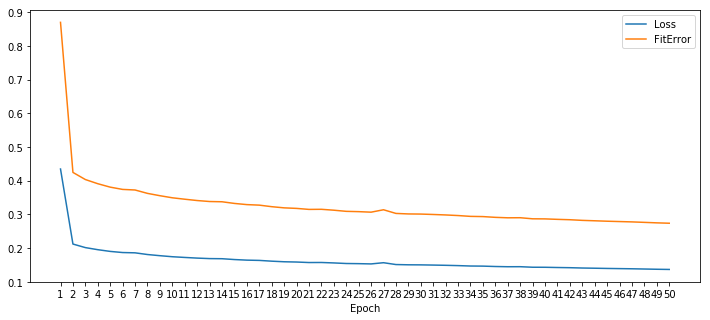

In [9]:
# Plot the training history.
model1.plot_training_history()

### 8. Evaluate fitted and testing results with various regression metrics

#### 8.1 Training results

In [10]:
# Get the model results information
fitted_result = model1.predict(train_tbl)
fitted_table = model1.valid_res_tbl
print(fitted_result['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read         16512
1  Number of Observations Used         16512
2           Mean Squared Error      0.274473
3                   Loss Error      0.137236


In [11]:
fitted_table.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value,P_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4.228583
1,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3.418713
2,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,2.637795
3,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697,2.575540
4,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992,2.667207


In [12]:
# Evaluate the MSE using dlpy.metrics.mean_squared_error
mse = mean_squared_error(fitted_table['house_value'], fitted_table['P_house_value'])
print('the mean squared error is {:.6f}'.format(mse))

the mean squared error is 0.274473


In [13]:
# Evaluate the MAE using dlpy.metrics.mean_absolute_error
mae = mean_absolute_error(fitted_table['house_value'], fitted_table['P_house_value'])
print('the mean absolute error is {:.6f}'.format(mae))

the mean absolute error is 0.357369


In [14]:
# Evaluate the explained variance score using dlpy.metrics.explained_variance_score
evs = explained_variance_score(fitted_table['house_value'], fitted_table['P_house_value'])
print('the {:.2f}% of target variable variance can be explained by the model'.format(evs*100))

the 79.63% of target variable variance can be explained by the model


#### 8.2 Prediction results

In [15]:
test_result = model1.predict(test_tbl)
test_result_table  = model1.valid_res_tbl
print(test_result['ScoreInfo'])

                         Descr         Value
0  Number of Observations Read          4128
1  Number of Observations Used          4128
2           Mean Squared Error      0.272699
3                   Loss Error      0.136349


In [16]:
test_result_table.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,house_value,P_house_value
0,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,4.305870
1,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,4.019447
2,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414,2.993425
3,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267,1.745030
4,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611,2.949648


In [17]:
# Evaluate the MSE using dlpy.metrics.mean_squared_error
mse = mean_squared_error(test_result_table['house_value'], test_result_table['P_house_value'])
print('the mean squared error is {:.6f}'.format(mse))

the mean squared error is 0.272699


In [18]:
# Evaluate the MAE using dlpy.metrics.mean_absolute_error
mae = mean_absolute_error(test_result_table['house_value'], test_result_table['P_house_value'])
print('the mean absolute error is {:.6f}'.format(mae))

the mean absolute error is 0.357170


In [19]:
# Evaluate the explained variance score using dlpy.metrics.explained_variance_score
evs = explained_variance_score(test_result_table['house_value'], test_result_table['P_house_value'])
print('the {:.2f}% of target variable variance can be explained by the model'.format(evs*100))

the 78.93% of target variable variance can be explained by the model


**Note: For more regression related metrics, please see the dlpy.metrics**